<a href="https://colab.research.google.com/github/sybenzvi/snxform-demo/blob/main/transim_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Transient Simulation

Brute-force simulation of transients. Using actual observing conditions (bright/dark conditions, moon illumination and angle, seeing, etc.), pass a transient model through the detector simulation and generate a transient flux. Then add it to actual galaxies.

In [1]:
import os

try:
    import snxform
except ImportError as e:
    !pip install git+https://github.com/desihub/desiutil.git@main
    !pip install git+https://github.com/desihub/desimodel.git@main
    !pip install git+https://github.com/desihub/desitarget.git@main
    !pip install git+https://github.com/desihub/desispec.git@main
    !pip install git+https://github.com/desihub/speclite.git@main
    !pip install git+https://github.com/DESI-UR/snxform.git@main

import snxform
from snxform import io

import numpy as np

from copy import copy
from urllib import request

from astropy.io import fits
from astropy.table import Table
from astropy import units as u

#- Necessary DESI pipeline files.
import desispec
from desispec.spectra import Spectra
from desispec.io import read_spectra, write_spectra
from desispec.coaddition import coadd, coadd_cameras, spectroperf_resample_spectra

#- Useful utilities for spectra.
from speclite import filters
rfilt = filters.load_filters('decam2014-r')

#- Detector simulation.
try:
    from desisim.scripts.quickspectra import sim_spectra
except ImportError as e:
    print(e)

#- Use sncosmo as the transients library.
import sncosmo

import matplotlib.pyplot as plt

No module named 'specsim'


## Download EDR File

The DESI EDR data are available from a [public folder at NERSC](https://data.desi.lbl.gov/public/edr/).

We want the "cumulative" spectrum files labeled "spectra" in the `redux` folder, because these are not coadded across multiple nights of data taking.

In [2]:
def get_spectro_data(tile: int, night: int, petal: int) -> list[str, str]:
    """Access both the spectra and the redshifts for a given observation.
    """
    specfile = f'spectra-{petal}-{tile}-thru{night}.fits'
    redshift = f'redrock-{petal}-{tile}-thru{night}.fits'

    baseurl = f'https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/tiles/cumulative/{tile}/{night}'
    if not (os.path.exists(specfile) and os.path.exists(redshift)):
        request.urlretrieve(os.path.join(baseurl, specfile), specfile)
        request.urlretrieve(os.path.join(baseurl, redshift), redshift)

    return specfile, redshift

In [3]:
specfile, redshift = get_spectro_data(96, 20210417, 4)

rfmap = Table.read(redshift, 'FIBERMAP')
zvals = Table.read(redshift, 'REDSHIFTS')

Read in the data from FITS, apply some basic target selection ([see here for details](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html)):
- No sky fibers (`OBJTYPE==TARGET`).
- `FIBERSTATUS` bit 0 (or 8).
- Bit 60 set in the `TARGET` bitmask (`BGS_ANY`).

In [5]:
cspectra = io.read_desi_spectra(specfile, redshift)
cspectra.fibermap

INFO:spectra.py:391:read_spectra: iotime 1.098 sec to read spectra-4-96-thru20210417.fits at 2024-05-21T19:15:34.777804


INFO:desiutil.log.dlm58.info:iotime 1.098 sec to read spectra-4-96-thru20210417.fits at 2024-05-21T19:15:34.777804


## Select Spectra + Transients

Grab all objects in this file identified with $z<1$ by the pipeline.

In [6]:
ztab = cspectra.extra_catalog
zselect = (ztab['ZWARN']==0) & (ztab['DELTACHI2'] >= 25) & (ztab['SPECTYPE']=='GALAXY') & (ztab['Z'] < 0.1)
ztab[zselect]

TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2
int64,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64
39633419130372718,0.09962796658315337,7.372646498752462e-06,0,7569.183263063431,505.3710084113758 .. -10.312279945050243,7892,GALAXY,--,10,984.8220856422558
39633419126180144,0.07764881622436783,4.162472890550265e-06,0,8330.028103232384,2014.9077210391943 .. -19.061907421101797,7908,GALAXY,--,10,3124.3205574816093
39633416332773557,0.07466068281242166,1.1119793333974573e-05,0,7904.624662540853,180.53213174795584 .. -38.23437928642948,7910,GALAXY,--,10,538.2372592464089
39633413518396096,0.07554692982959754,6.090292374882114e-06,0,13556.578722685575,-580.2950021650696 .. -245.34131529611196,7915,GALAXY,--,10,9356.987622997724
39633413518395569,0.0792542538952669,2.7285304028437e-06,0,9183.2914737463,3175.057354424323 .. 86.2692394738691,7888,GALAXY,--,10,14185.176486611366


### Access Exposure Data

This is the [EDR "fuji" CSV tile table](https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/exposures-fuji.csv) with some additional fields added, such as moon illumination and position.

Note that only the SV3 exposures are in the table.

In [7]:
expcsv = os.path.join(snxform.src_path, 'etc/exposures-fuji-sv3.ecsv')

exptab = Table.read(expcsv)
exptab

NIGHT,EXPID,TILEID,TILERA,TILEDEC,MJD,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBDARK,TSNR2_GPBBRIGHT,TSNR2_GPBBACKUP,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GPB_EFFTIME_DARK,GPB_EFFTIME_BRIGHT,GPB_EFFTIME_BACKUP,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA,SKYRA,SKYDEC,MOON_ILLUMINATION,MOON_ZD_DEG,MOON_SEP_DEG,FWHM_ASEC,TRANSPARENCY,SKY_MAG_AB,FIBER_FRACFLUX,FIBER_FRACFLUX_ELG,FIBER_FRACFLUX_BGS
int64,int64,int64,float64,float64,float64,str3,str6,str6,str9,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20210405,83522,12,150.04,2.286,59310.11613139,sv3,bright,bright,sv3bright,1087.2,1.9,220.0,bright,0.9,1.268,0.021,1.242,2.0,0.2,0.1,0.1,0.2,13.7,19.4,4.0,36.2,1.8,1.8,1.9,2.4,1.7,2.1,2.7,0.074,1.275,0.469,0.351,0.164,0.058,0.06,0.061,1.248,20.186,20.865,20.254,19.24,1.9,1.8,1.9,1.8,150.045192,2.27918,0.32165655238961327,169.97905325303662,151.56973009087207,1.2810781090848906,0.07630297572569356,20.198798889675196,0.46873832443347047,0.3516396983470239,0.1651608369709665
20210405,83524,23,150.04,2.286,59310.14064081,sv3,backup,backup,sv3backup,599.5,78.3,30.0,backup,0.9,1.198,0.021,1.38,60.9,7.3,1.8,5.0,4.6,473.4,685.3,135.5,1068.3,61.8,62.7,66.3,52.7,59.3,71.2,78.3,0.496,1.35,0.455,0.343,0.162,0.367,0.381,0.39,1.191,20.813,21.932,20.931,19.31,62.3,61.6,66.2,62.3,150.043079,2.27986,0.3195127315941897,169.89455362051018,151.82971360831672,1.3502111085861985,0.4949112245181938,20.813134188185895,0.45563334242062536,0.34348071784597145,0.1618446000838954
20210405,83525,50,179.599,0.12,59310.15083031,sv3,backup,backup,sv3backup,341.8,80.9,30.0,backup,0.9,1.588,0.024,1.727,61.4,8.1,2.0,5.5,3.7,521.6,737.5,143.9,1103.6,67.9,69.7,73.0,42.1,63.8,75.6,80.9,1.075,1.66,0.337,0.268,0.13,0.592,0.644,0.679,1.573,20.822,21.899,20.941,19.119,77.9,76.7,90.8,77.9,179.609871,0.11016,0.3186583197238284,168.70318022166424,127.59868646861702,1.660374806192365,1.0761869196764768,20.82199234836667,0.3366545120437453,0.267556737254928,0.12978446958949902
20210405,83526,39,179.599,0.12,59310.15691424,sv3,bright,bright,sv3bright,491.1,209.6,220.0,bright,0.9,1.535,0.024,1.446,224.0,23.5,5.8,16.2,14.0,1497.4,2246.4,424.7,2974.7,199.3,201.9,209.6,160.4,194.5,223.1,218.0,1.116,1.331,0.441,0.334,0.158,0.822,0.845,0.862,1.515,20.858,21.914,20.991,19.174,245.8,224.7,245.8,242.6,179.608859,0.110619,0.3179765407221857,167.4098187492401,127.67073102354172,1.330533503691481,1.1153485366408546,20.857570201417026,0.4400457924534194,0.3332921706256655,0.15740177096643126
20210405,83527,66,183.106,0.12,59310.16505076,sv3,bright,bright,sv3bright,572.3,178.2,220.0,bright,0.9,1.549,0.022,1.56,219.9,20.0,4.9,13.7,11.6,1273.0,1892.2,361.2,2612.6,169.3,171.7,178.2,133.0,163.8,189.7,191.5,1.06,1.483,0.393,0.303,0.144,0.66,0.703,0.73,1.524,20.87,21.893,21.005,19.254,215.3,192.4,215.3,186.9,183.116122,0.110499,0.31712639902081186,165.51623410615218,124.72309295033482,1.4840753679720609,1.0622639276830679,20.869874103784944,0.39216656696930385,0.3020814663922581,0.1441418043133455
20210405,83528,93,189.944,61.918,59310.17592541,sv3,bright,bright,sv3bright,1080.6,4.6,220.0,bright,0.9,1.321,0.013,1.452,4.1,0.5,0.1,0.4,0.7,32.9,43.2,8.8,80.3,4.3,4.5,4.6,7.5,3.7,4.6,5.9,0.085,1.039,0.574,0.413,0.189,0.074,0.073,0.073,1.304,20.13,21.409

Extract the observing conditions for these measurements.

In [8]:
tileid, night = [np.unique(cspectra.exp_fibermap[_])[0] for _ in ['TILEID', 'NIGHT']]

exposure_data = exptab[(exptab['TILEID'] == tileid) & (exptab['NIGHT'] == night)]
obsdict = {
    'SEEING'   : np.average(exposure_data['FWHM_ASEC']),
    'EXPTIME'  : np.sum(exposure_data['EXPTIME']),
    'AIRMASS'  : np.average(exposure_data['AIRMASS']),
    'MOONFRAC' : np.average(exposure_data['MOON_ILLUMINATION']),
    'MOONALT'  : np.average(exposure_data['MOON_ZD_DEG']),
    'MOONSEP'  : np.average(exposure_data['MOON_SEP_DEG']),
}

program = exposure_data['PROGRAM'][0]

obsdict, program

({'SEEING': 1.0539937154629542,
  'EXPTIME': 324.9,
  'AIRMASS': 1.156,
  'MOONFRAC': 0.3074972080265049,
  'MOONALT': 84.8066646822632,
  'MOONSEP': 69.48445442830277},
 'bright')

In [9]:
exposure_data

NIGHT,EXPID,TILEID,TILERA,TILEDEC,MJD,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBDARK,TSNR2_GPBBRIGHT,TSNR2_GPBBACKUP,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GPB_EFFTIME_DARK,GPB_EFFTIME_BRIGHT,GPB_EFFTIME_BACKUP,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA,SKYRA,SKYDEC,MOON_ILLUMINATION,MOON_ZD_DEG,MOON_SEP_DEG,FWHM_ASEC,TRANSPARENCY,SKY_MAG_AB,FIBER_FRACFLUX,FIBER_FRACFLUX_ELG,FIBER_FRACFLUX_BGS
int64,int64,int64,float64,float64,float64,str3,str6,str6,str9,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20210417,85196,96,189.69,61.868,59322.27921726,sv3,bright,bright,sv3bright,324.9,226.3,220.0,bright,0.9,1.156,0.013,1.098,254.7,26.3,6.1,17.6,13.8,1616.1,2352.6,444.7,2925.6,216.8,226.0,226.3,157.3,203.7,233.6,214.4,1.052,1.054,0.578,0.415,0.191,0.989,0.972,0.969,1.157,21.161,21.882,21.176,19.496,224.0,210.5,224.0,261.5,189.688371,61.87373,0.3074972080265049,84.8066646822632,69.48445442830277,1.0539937154629542,1.049430542114513,21.16101390514425,0.5782347167616813,0.4150192856288871,0.19041729739585544


### Transient Detector Simulation

Extract the redshifts for the transients we want to simulate.

We're going to then scale the transient flux in the r band to the observed spectra. This is just a simple number, which we can use to manage things like the brightness of the source, offsets of the source from the center of the fiber, etc. I.e., anything that can change the relative brightness of source and galaxy.

In [10]:
targetid = ztab['TARGETID'][zselect]
z = ztab['Z'][zselect]
sp = ztab['SPECTYPE'][zselect]
sb = ztab['SUBTYPE'][zselect]
if np.ma.is_masked(sb):
    sb = np.full_like(sb, '')
coeff = ztab['COEFF'][zselect]

wave = cspectra.wave['brz']
flux = cspectra.flux['brz']
ivar = cspectra.ivar['brz']

#### Galaxy Flux Normalization

Zero-pad the galaxy spectra so that we can compute the r-band flux using the DECam r filter in speclite. The particular filter isn't super important, as we care more about the galaxy-transient flux ratio...

In [11]:
pad_below = np.arange(wave[0]-0.8, 3300-0.8, -0.8)[::-1]
i = len(pad_below)
j = i + len(wave)
pad_above = pad_above = np.arange(wave[-1]+1, 10991)
wave_padded = np.concatenate([pad_below, wave, pad_above]) *u.Angstrom

nf, nw = np.sum(zselect), len(wave_padded)
flux_padded = np.zeros((nf, nw))
flux_padded[:, i:j] = flux[zselect]
flux_padded = flux_padded * 1e-17 * u.erg/(u.cm**2 * u.s * u.Angstrom)

In [12]:
galnorm = rfilt.get_ab_maggies(flux_padded, copy(wave_padded))['decam2014-r']
galnorm

<Column name='decam2014-r' dtype='float64' length=5>
 6.057280743320338e-09
2.4932230779364344e-08
 8.027352046346736e-09
 5.509783528006219e-08
 3.406620474303335e-08

#### Transient Flux Normalization

Generate an r-band flux normalization for a transient model, similar to what we did for the galaxy.

In this case, we'll simulate a SN Ia at max light, at the redshift of the underlying spectrum (according to the pipeline). We are ignoring extinction, but we don't care for now.

In [13]:
model = sncosmo.Model('hsiao')
wavemodel = wave

nf, nw = np.sum(zselect), len(wavemodel)
fluxmodel = np.zeros((nf, nw))

for k, z in enumerate(ztab['Z'][zselect]):
    model.set(z=z, t0=0)
    fluxmodel[k] = model.flux(0, wavemodel)

pad_below = np.arange(wave[0]-0.8, 3300-0.8, -0.8)[::-1]
i = len(pad_below)
j = i + len(wave)
pad_above = pad_above = np.arange(wave[-1]+1, 10991)
wavemodel_padded = np.concatenate([pad_below, wave, pad_above]) *u.Angstrom

nf, nw = np.sum(zselect), len(wavemodel_padded)
fluxmodel_padded = np.zeros((nf, nw))
fluxmodel_padded[:, i:j] = fluxmodel
fluxmodel_padded = fluxmodel_padded * 1e-17 * u.erg/(u.cm**2 * u.s * u.Angstrom)

trnnorm = rfilt.get_ab_maggies(fluxmodel_padded, copy(wavemodel_padded))['decam2014-r']
trnnorm

<Column name='decam2014-r' dtype='float64' length=5>
1.0346178853705669e-17
  9.95373962489761e-18
 9.911046268498862e-18
 9.923592131697448e-18
 9.977451899413734e-18

Scale the transient spectrum to the galaxy spectrum using the r-band normalization.

In [14]:
scale = 0.9

trafactor = galnorm / trnnorm * scale
fluxmodel = fluxmodel * trafactor[:, np.newaxis]

In [15]:
trafactor

<Column name='decam2014-r' dtype='float64' length=5>
526914597.75371397
 2254329382.426329
 728945930.2268307
 4996986080.641532
3072887203.8492656

### Combined Spectra + Model

Here we'll have to **cheat for this demo**: we can't run the quick spectral simulation because it requires some metadata in a password-protected SVN repository.

So instead, we'll just add the noiseless model to the observed spectrum.

In [17]:
a = cspectra[zselect]
flux_tot = a.flux['brz'] + fluxmodel

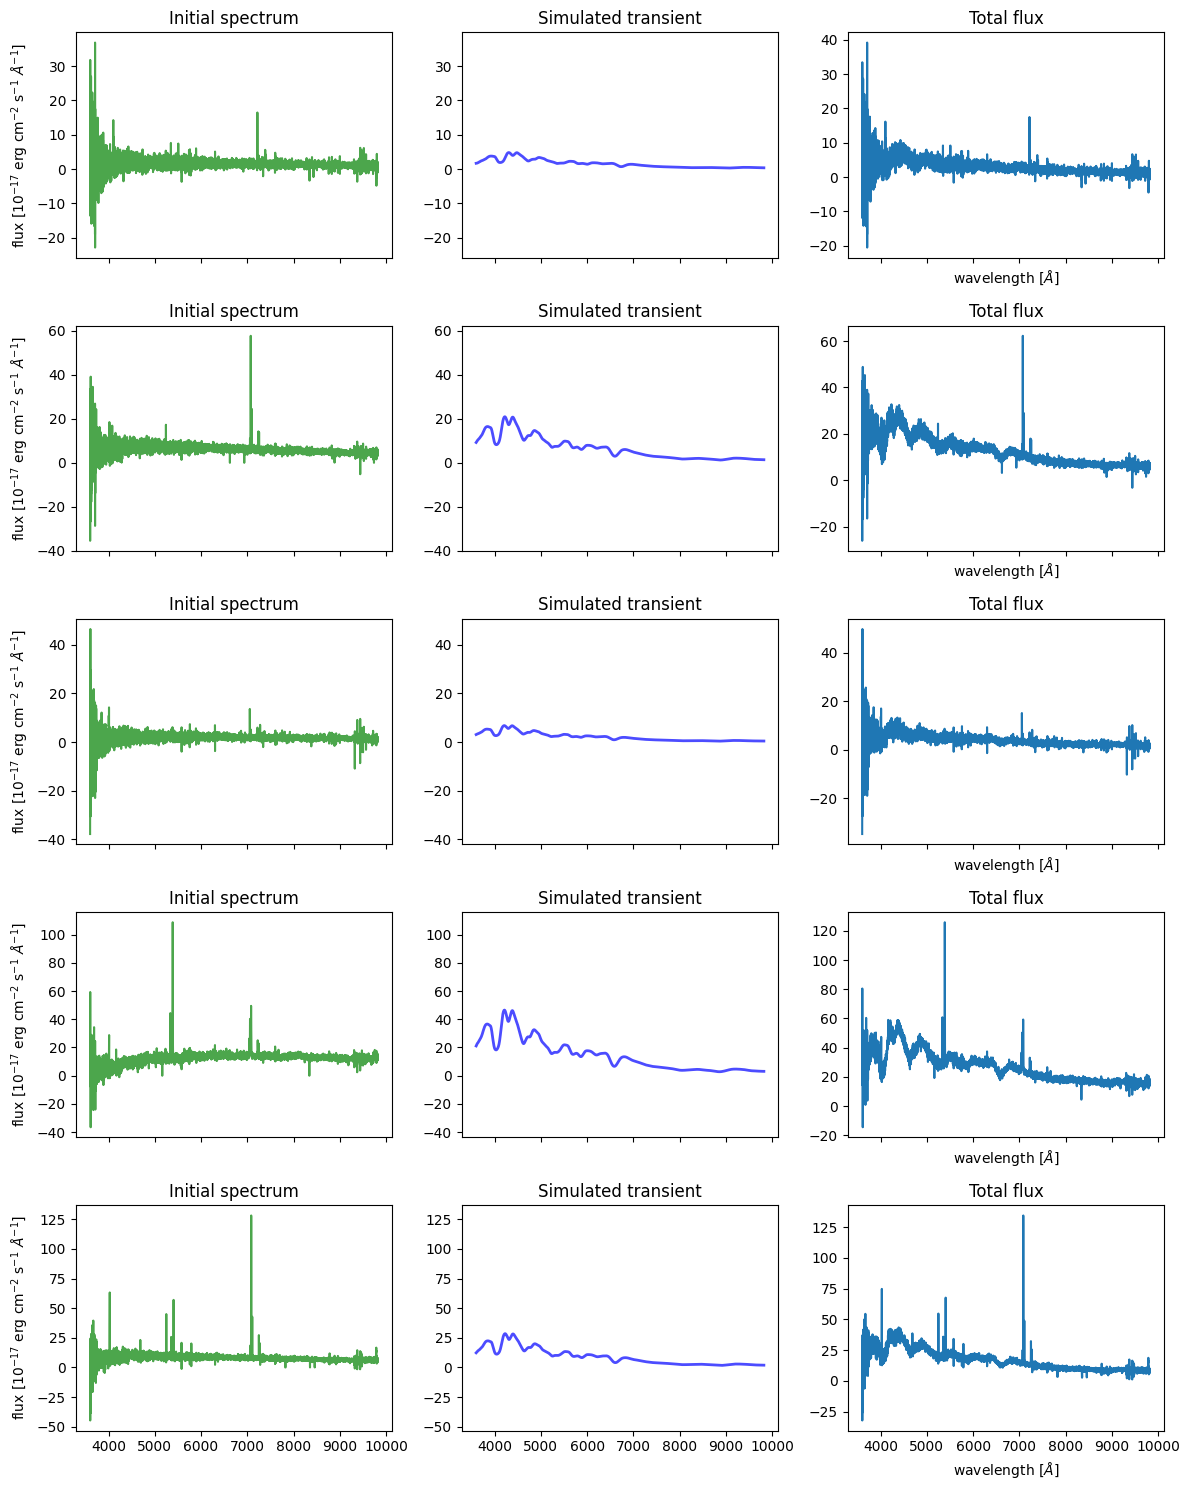

In [18]:
fig, axes = plt.subplots(a.num_spectra(), 3, figsize=(12,3*a.num_spectra()), sharex=True, tight_layout=True)

for i in range(a.num_spectra()):
    ax = axes[i][0]
    ax.plot(a.wave['brz'], a.flux['brz'][i], color='green', alpha=0.7)
    ax.set(title='Initial spectrum',
           ylabel=r'flux [10$^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
    ylim = ax.get_ylim()

    ax = axes[i][1]
    ax.plot(wavemodel, fluxmodel[i], color='blue', lw=2, alpha=0.7)
    ax.set(ylim=ylim)
    ax.set(title='Simulated transient')

    ax = axes[i][2]
    ax.plot(wavemodel, flux_tot[i])
    ax.set(title='Total flux',
           xlabel=r'wavelength [$\AA$]')